# Лабораторная 3.2 и 3.3
# Применение логистической регрессии для решения задачи бинарной классификации
# 3.2 Часть 1.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [29]:
titanic = pd.read_csv('data/Titanic.csv', sep=',')
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Приведем датасет к пригодному для обучения виду

In [30]:
titanic_new = titanic.copy()
titanic_new = titanic_new.dropna()
titanic_new.shape

(183, 12)

После удаления всех строк, содержащих пустые значения имеем всего 183 строки из 891.

Посмотрим на количество NaN объектов в каждом столбце прежде чем переходить далее

In [31]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Очень много пустых значений содержаться в колонке ```Cabin```. Как раз ее и колонки ```Name``` и ```Ticket``` 
попадают под условия удаления, так как они не числовые и не являются ```Sex``` и ```Embarked```.

Поэтому сначала удалим колонки, а только потом удалим строки с путсыми значениями

In [32]:
titanic_new = titanic.copy()
titanic_new = titanic_new.drop(['Name', 'Ticket', 'Cabin'], axis=1)
titanic_new = titanic_new.dropna()
titanic_new.shape

(712, 9)

Теперь мы имеем на 529 строк больше из 891-й, что должно увеличить качество модели.

Также удалим столбец ```PassengerId``` и сделаем бинарными категориальные данные ```Sex``` и ```Embarked```

In [33]:
titanic_new = titanic_new.drop('PassengerId', axis=1)
titanic_new = pd.get_dummies(titanic_new)
titanic_new.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


In [34]:
print('Процент потерянных данных: ', (1 - len(titanic_new)/len(titanic))*100, '%')

Процент потерянных данных:  20.08978675645342 %


Разобьем данные, обучим ```логистическую регрессию``` и посмотрим на точность модели, а также оценим влияние признака 
```Embarked``` на качество нашей модели.

На оценки влияния признаков в логистической регрессии:

_Если характеристики имеют разные масштабы или единицы измерения, модель может присваивать более высокие коэффициенты (и, следовательно, более высокую_ _важность) характеристикам с большими значениями, даже если они не обязательно более важны._

_Для каждого признака при стандартизации вычитается среднее значение и делится на стандартное отклонение._

_Это приводит к тому, что характеристики имеют среднее значение 0, стандартное отклонение 1 и находятся примерно в одном масштабе._

_Когда признаки стандартизированы, величина коэффициентов в логистической регрессии напрямую отражает важность каждого признака._

In [38]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(titanic_new.drop('Survived', axis=1), titanic_new['Survived'], test_size=0.33, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Точность полученной модели: ', accuracy_score(y_test, y_pred))

Точность полученной модели:  0.7787234042553192


Влияние признаков модели:

<Axes: ylabel='Feature'>

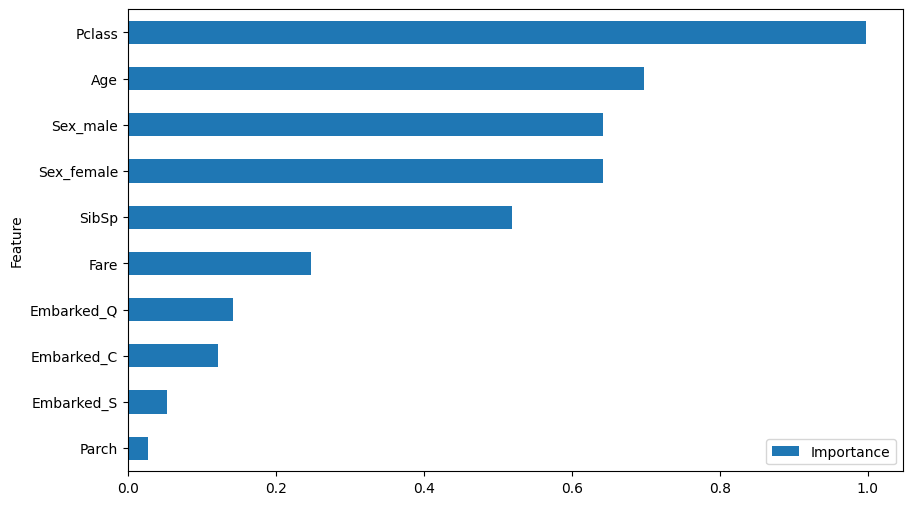

In [45]:
coefficients = clf.coef_[0]

feature_importance = pd.DataFrame({'Feature': titanic_new.drop('Survived', axis=1).columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Мы получили влияние признаков, но Embarked разбит на 3 бинарных признака. Поэтому найдем их сумму, 
чтобы оцень полное влияние данного признака

In [63]:
feature_importance = pd.DataFrame({'Feature': titanic_new.drop('Survived', axis=1).columns, 'Importance': np.abs(coefficients)})
feature_importance

,Feature,Importance
0,Pclass,0.997093
1,Age,0.697011
2,SibSp,0.519832
3,Parch,0.027773
4,Fare,0.248275
5,Sex_female,0.642758
6,Sex_male,0.642758
7,Embarked_C,0.122634
8,Embarked_Q,0.141748
9,Embarked_S,0.052652


In [64]:
feature_importance.loc[10] = ['Embarked', feature_importance.iloc[7:10, 1].sum()]
feature_importance = feature_importance.drop(feature_importance.index[7:10], axis=0)
feature_importance

,Feature,Importance
0,Pclass,0.997093
1,Age,0.697011
2,SibSp,0.519832
3,Parch,0.027773
4,Fare,0.248275
5,Sex_female,0.642758
6,Sex_male,0.642758
10,Embarked,0.317034


Заодно повторим тоже самое с признаком ```Sex```

In [67]:
feature_importance.loc[11] = ['Sex', feature_importance.iloc[[5, 6], 1].sum()]
feature_importance = feature_importance.drop(feature_importance.index[[5, 6]], axis=0)
feature_importance

,Feature,Importance
0,Pclass,0.997093
1,Age,0.697011
2,SibSp,0.519832
3,Parch,0.027773
4,Fare,0.248275
10,Embarked,0.317034
11,Sex,1.285516


<Axes: ylabel='Feature'>

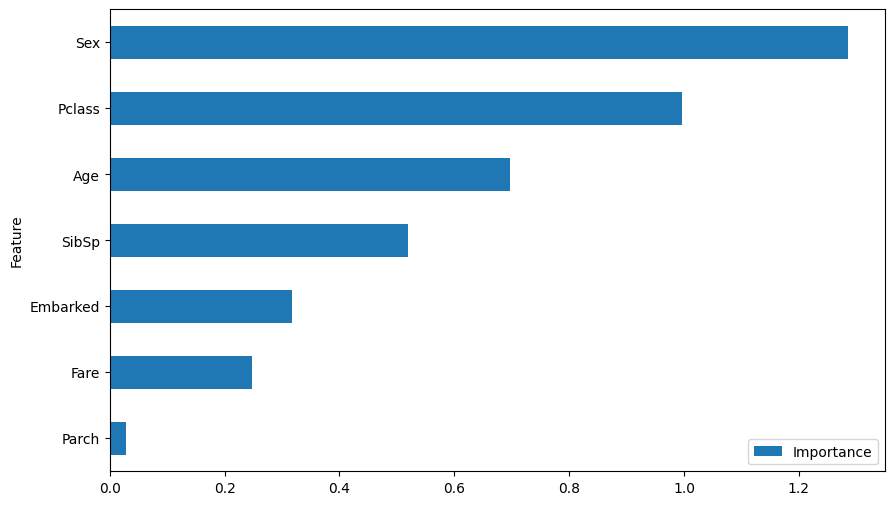

In [68]:
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Как видим, ```Embarked``` не имеет сильного влияния на нашу модель